# 02 — Optimal Time Engagement Model Training & Inference

**Intent:** Train (or reuse) a send-time model and show how to generate and explain personalized 7×24 recommendations.

This notebook is a follow-up to `01_eda_and_synthesis.ipynb`.

It **references and reuses the model training code** from `src/train.py` for:
- temporal split
- model fitting (naive baseline, logistic baseline, LightGBM)
- probability calibration
- top-3 hit rate evaluation

It also demonstrates **inference results** on a real customer profile and on a what-if scenario.

**References (optional reading):**
- Ke, G. et al. (2017). *LightGBM: A Highly Efficient Gradient Boosting Decision Tree*. NeurIPS.
- Lundberg, S. M., & Lee, S.-I. (2017). *A Unified Approach to Interpreting Model Predictions* (SHAP). NeurIPS.
- Niculescu-Mizil, A., & Caruana, R. (2005). *Predicting Good Probabilities with Supervised Learning*. ICML.

In [1]:
import sys
import numpy as np
import pandas as pd
import joblib
import shap
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import roc_auc_score, brier_score_loss

PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.train import time_split, fit_models, compute_top3_hit_rate
from src.feature_engineering import FEATURE_COLUMNS, DAY_NAMES, build_168_grid

EVENT_FEATURES_CSV = PROJECT_ROOT / 'data' / 'processed' / 'event_features.csv'
CUSTOMER_FEATURES_CSV = PROJECT_ROOT / 'data' / 'processed' / 'customer_features.csv'
EXPLAINER_PATH = PROJECT_ROOT / 'models' / 'shap_explainer.pkl'

pd.set_option('display.max_columns', 100)

## 0. Load Data

**Intent:** Load the processed event/customer features and do quick sanity checks (shapes, time range, base open rate).

In [2]:
assert EVENT_FEATURES_CSV.exists(), f"Missing file: {EVENT_FEATURES_CSV}"
assert CUSTOMER_FEATURES_CSV.exists(), f"Missing file: {CUSTOMER_FEATURES_CSV}"

event_df = pd.read_csv(EVENT_FEATURES_CSV, parse_dates=['send_datetime'])
customer_features = pd.read_csv(CUSTOMER_FEATURES_CSV)
customer_features['customer_id'] = customer_features['customer_id'].astype(np.int64)

print('event_features shape:', event_df.shape)
print('customer_features shape:', customer_features.shape)
print('send_datetime range:', event_df['send_datetime'].min(), '->', event_df['send_datetime'].max())
print('event open rate:', round(event_df['opened'].mean(), 4))

event_features shape: (106154, 23)
customer_features shape: (5335, 13)
send_datetime range: 2009-12-01 06:00:00 -> 2011-12-31 12:00:00
event open rate: 0.2353


## 1. Train Using `src/train.py` Logic

**Intent:** Fit baseline and gradient-boosted models on a time-based split, then evaluate both ranking quality (AUC) and probability quality (Brier score).

In [3]:
split = time_split(event_df)
models = fit_models(split)

# Unpack for cleaner access throughout the notebook
lgbm = models['lgbm']
calibrator = models['calibrator']

auc_naive = roc_auc_score(split.y_test, models['naive_scores'])
auc_lr = roc_auc_score(split.y_test, models['lr_scores'])
auc_lgbm = roc_auc_score(split.y_test, models['lgbm_scores'])
brier_lgbm = brier_score_loss(split.y_test, models['lgbm_scores'])

metrics_df = pd.DataFrame([
    {'model': 'Naive Random', 'test_auc': auc_naive},
    {'model': 'Logistic (send_hour, send_dow)', 'test_auc': auc_lr},
    {'model': 'LightGBM (20 features, calibrated)', 'test_auc': auc_lgbm},
]).sort_values('test_auc', ascending=False)

print('Split sizes:', {'train': len(split.X_train), 'val': len(split.X_val), 'test': len(split.X_test)})
print('Brier (LightGBM calibrated):', round(brier_lgbm, 6))
metrics_df

Split sizes: {'train': 76020, 'val': 12944, 'test': 12464}
Brier (LightGBM calibrated): 0.178859


,model,test_auc
2,"LightGBM (20 features, calibrated)",0.523493
1,"Logistic (send_hour, send_dow)",0.511395
0,Naive Random,0.503879


In [4]:
top3_overall, top3_by_segment = compute_top3_hit_rate(
    lgbm, calibrator, split.test_df, customer_features
)

print('Top-3 hit rate (overall):', round(top3_overall, 4))
segment_df = top3_by_segment.rename('top3_hit_rate').reset_index().rename(columns={'rfm_segment': 'segment'})
segment_df

Top-3 hit rate (overall): 0.0507


,segment,top3_hit_rate
0,Other,0.059211
1,Loyal,0.055215
2,Champions,0.047936
3,At Risk,0.033654
4,Hibernating,0.000000


## 2. Inference on a Real Customer

**Intent:** Turn a single customer profile into a 7×24 (168-slot) grid using the shared `build_168_grid` utility and score every candidate send time.

In [5]:
def score_grid(grid: pd.DataFrame) -> np.ndarray:
    raw = lgbm.predict_proba(grid[FEATURE_COLUMNS])[:, 1]
    return calibrator.predict(raw)


def top3_slots(grid: pd.DataFrame, scores: np.ndarray) -> pd.DataFrame:
    out = grid[['send_hour', 'send_dow']].copy()
    out['probability'] = scores
    out['day_name'] = out['send_dow'].map(lambda d: DAY_NAMES[d])
    return out.sort_values('probability', ascending=False).head(3).reset_index(drop=True)

In [6]:
eligible = customer_features[customer_features['frequency'] >= 5].copy()
sample_customer = eligible.sort_values('customer_id').iloc[0]
customer_id = int(sample_customer['customer_id'])

customer_grid = build_168_grid(sample_customer)
customer_scores = score_grid(customer_grid)
customer_top3 = top3_slots(customer_grid, customer_scores)

print('Sample customer_id:', customer_id)
customer_top3

Sample customer_id: 12747


,send_hour,send_dow,probability,day_name
0,12,5,0.275107,Saturday
1,12,0,0.275107,Monday
2,16,2,0.275107,Wednesday


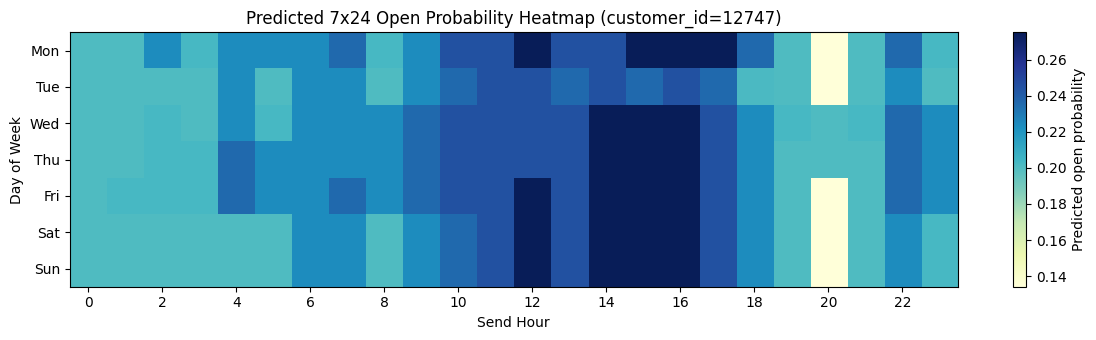

In [7]:
heatmap_df = customer_grid[['send_dow', 'send_hour']].copy()
heatmap_df['probability'] = customer_scores
heatmap = heatmap_df.pivot(index='send_dow', columns='send_hour', values='probability').sort_index()

plt.figure(figsize=(12, 3.5))
plt.imshow(heatmap.values, aspect='auto', cmap='YlGnBu')
plt.colorbar(label='Predicted open probability')
plt.yticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xticks(range(0, 24, 2), range(0, 24, 2))
plt.xlabel('Send Hour')
plt.ylabel('Day of Week')
plt.title(f'Predicted 7x24 Open Probability Heatmap (customer_id={customer_id})')
plt.tight_layout()
plt.show()

## 3. SHAP Explanation for Top Recommended Slot

**Intent:** Explain *why* the model likes the top slot by attributing the prediction to feature contributions.

In [8]:
# Load the saved SHAP explainer for consistency with API behaviour
explainer = joblib.load(EXPLAINER_PATH)

top_slot = customer_top3.iloc[0]
top_row = customer_grid[
    (customer_grid['send_hour'] == top_slot['send_hour']) &
    (customer_grid['send_dow'] == top_slot['send_dow'])
].iloc[0]

x = pd.DataFrame([top_row[FEATURE_COLUMNS].to_dict()])
shap_vals = explainer.shap_values(x)

# LightGBM binary classifiers return different SHAP shapes depending on version:
# - list of 2 arrays (class 0, class 1) in older shap versions
# - single 2D array in newer versions
# - single 3D array (samples x features x classes) in some configurations
if isinstance(shap_vals, list):
    sv = np.asarray(shap_vals[1 if len(shap_vals) > 1 else 0])[0]
else:
    arr = np.asarray(shap_vals)
    sv = arr[0] if arr.ndim == 2 else arr[0, :, 1]

shap_df = pd.DataFrame({
    'feature': FEATURE_COLUMNS,
    'value': [float(x.iloc[0][f]) for f in FEATURE_COLUMNS],
    'contribution': sv.astype(float)
})
shap_df['abs_contribution'] = shap_df['contribution'].abs()
shap_df.sort_values('abs_contribution', ascending=False).head(10)

,feature,value,contribution,abs_contribution
15,hour_delta_from_modal,2.000000,0.119224,0.119224
2,purchase_hour_entropy,0.620114,0.093961,0.093961
5,frequency,26.000000,-0.045944,0.045944
6,monetary_total,8846.680000,0.045738,0.045738
7,tenure_days,730.000000,-0.043112,0.043112
9,unique_products,85.000000,0.042764,0.042764
12,send_dow,5.000000,0.037823,0.037823
3,avg_daily_txn_count,0.338356,0.035138,0.035138
18,hour_x_entropy,7.441363,0.033529,0.033529
4,recency_days,2.000000,-0.015242,0.015242


## 4. What-if Inference Example

**Intent:** Change a few customer attributes (recency, frequency, "habit hour" entropy) and observe how the recommended slot shifts.

In [9]:
what_if_profile = pd.Series({
    'modal_purchase_hour': 10,
    'modal_purchase_dow': int(customer_features['modal_purchase_dow'].median()),
    'purchase_hour_entropy': 0.30,
    'avg_daily_txn_count': float(customer_features['avg_daily_txn_count'].median()),
    'recency_days': 30.0,
    'frequency': 10,
    'monetary_total': float(customer_features['monetary_total'].median()),
    'tenure_days': int(customer_features['tenure_days'].median()),
    'country_uk': 1,
    'unique_products': int(customer_features['unique_products'].median()),
    'cancellation_rate': 0.0,
})

what_if_grid = build_168_grid(what_if_profile)
what_if_scores = score_grid(what_if_grid)
what_if_top3 = top3_slots(what_if_grid, what_if_scores)
what_if_top3

,send_hour,send_dow,probability,day_name
0,12,3,0.245331,Thursday
1,9,2,0.245331,Wednesday
2,9,5,0.245331,Saturday


## 5. Notebook Summary

**Intent:** Store the most important evaluation numbers and example recommendations in one small dictionary.

In [10]:
summary = {
    'auc_naive': round(float(auc_naive), 4),
    'auc_logistic': round(float(auc_lr), 4),
    'auc_lgbm_calibrated': round(float(auc_lgbm), 4),
    'brier_lgbm_calibrated': round(float(brier_lgbm), 6),
    'top3_hit_rate_overall': round(float(top3_overall), 4),
    'sample_customer_id': customer_id,
    'sample_customer_best_slot': f"DOW={int(customer_top3.iloc[0]['send_dow'])}, HOUR={int(customer_top3.iloc[0]['send_hour'])}",
    'what_if_best_slot': f"DOW={int(what_if_top3.iloc[0]['send_dow'])}, HOUR={int(what_if_top3.iloc[0]['send_hour'])}",
}
summary

{'auc_naive': 0.5039,
 'auc_logistic': 0.5114,
 'auc_lgbm_calibrated': 0.5235,
 'brier_lgbm_calibrated': 0.178859,
 'top3_hit_rate_overall': 0.0507,
 'sample_customer_id': 12747,
 'sample_customer_best_slot': 'DOW=5, HOUR=12',
 'what_if_best_slot': 'DOW=3, HOUR=12'}